In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.optimizers import SGD

# dimensions of our images.
img_width, img_height = 300, 300

train_data_dir = 'data/tweaked_data/images/'
epochs = 1
batch_size = 16
number_classes = 20

/Users/cliff/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(number_classes, activation='softmax'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['categorical_accuracy'])

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_data_dir, # same directory as training data
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = epochs)


model.save_weights('first_try.h5')

Found 88491 images belonging to 20 classes.
Found 22113 images belonging to 20 classes.
Epoch 1/1
5530/5530 [==============================] - 24672s 4s/step - loss: 8.4247 - categorical_accuracy: 0.4772 - val_loss: 8.4221 - val_categorical_accuracy: 0.4775


In [4]:
import sklearn.metrics as metrics
import numpy as np

#REF https://stackoverflow.com/questions/50825936/confusion-matrix-on-images-in-cnn-keras
# Predict classes
test_generator = ImageDataGenerator()
test_data_generator = test_generator.flow_from_directory(
    train_data_dir, # Put your path here
     target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle=False)
test_steps_per_epoch = np.math.ceil(test_data_generator.samples / test_data_generator.batch_size)

print('predictions')
predictions = model.predict_generator(test_data_generator, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=1)

print('predictions done')
# Get ground-truth classes and class-labels
true_classes = test_data_generator.classes
class_labels = list(test_data_generator.class_indices.keys())  

print('getting metrics')
# Use scikit-learn to get statistics
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 


Found 110604 images belonging to 20 classes.
predictions
predictions done
getting metrics
              precision    recall  f1-score   support

   aeroplane       0.00      0.00      0.00      3195
     bicycle       0.00      0.00      0.00      2080
        bird       0.00      0.00      0.00      3746
        boat       0.00      0.00      0.00      1648
      bottle       0.00      0.00      0.00      3089
         bus       0.00      0.00      0.00       761
         car       0.00      0.00      0.00      5519
         cat       0.00      0.00      0.00     10823
       chair       0.00      0.00      0.00      2841
         cow       0.00      0.00      0.00      1369
 diningtable       0.00      0.00      0.00       402
         dog       0.48      1.00      0.65     52793
       horse       0.00      0.00      0.00      2250
   motorbike       0.00      0.00      0.00       875
      person       0.00      0.00      0.00     10699
 pottedplant       0.00      0.00      0.00  

/Users/cliff/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [5]:
from sklearn.metrics import confusion_matrix

class_values = list(test_data_generator.class_indices.values())

matrix = confusion_matrix(true_classes, predicted_classes,class_values)

print(matrix)

[[    0     0     0     0     0     0     0     0     0     0     0  3195
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0  2080
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0  3746
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0  1648
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0  3089
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0   761
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0  5519
      0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0 10823
      0     0     0     0     0     0     0     0]


Confusion matrix, without normalization


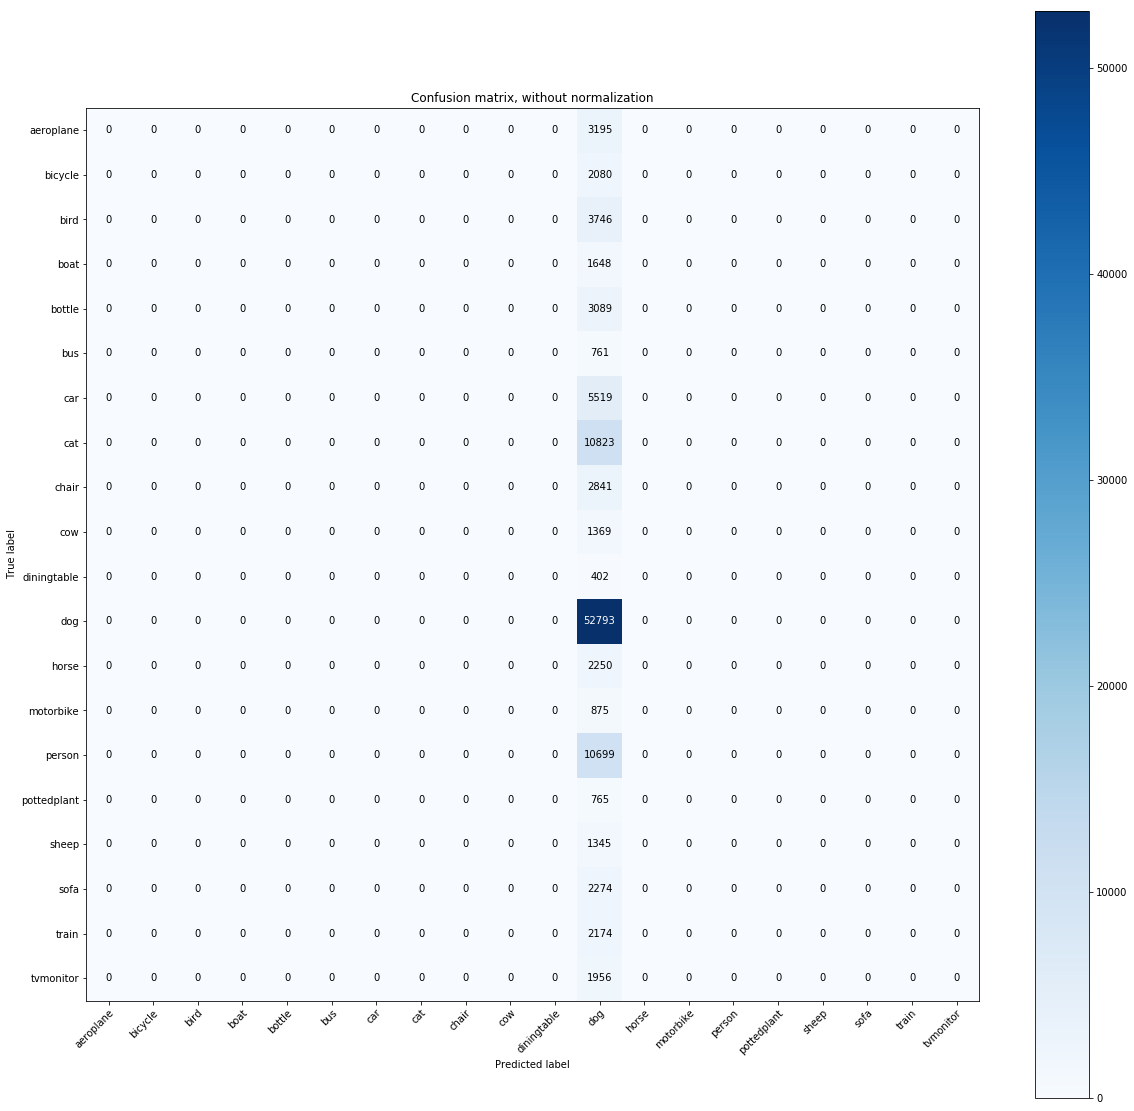

In [7]:
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=class_labels, yticklabels=class_labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    #fig.tight_layout()
    return ax

np.set_printoptions(precision=2)
t_c = unique_labels(list(test_data_generator.class_indices.values()))

# Plot non-normalized confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, classes=t_c,title='Confusion matrix, without normalization')



Normalized confusion matrix


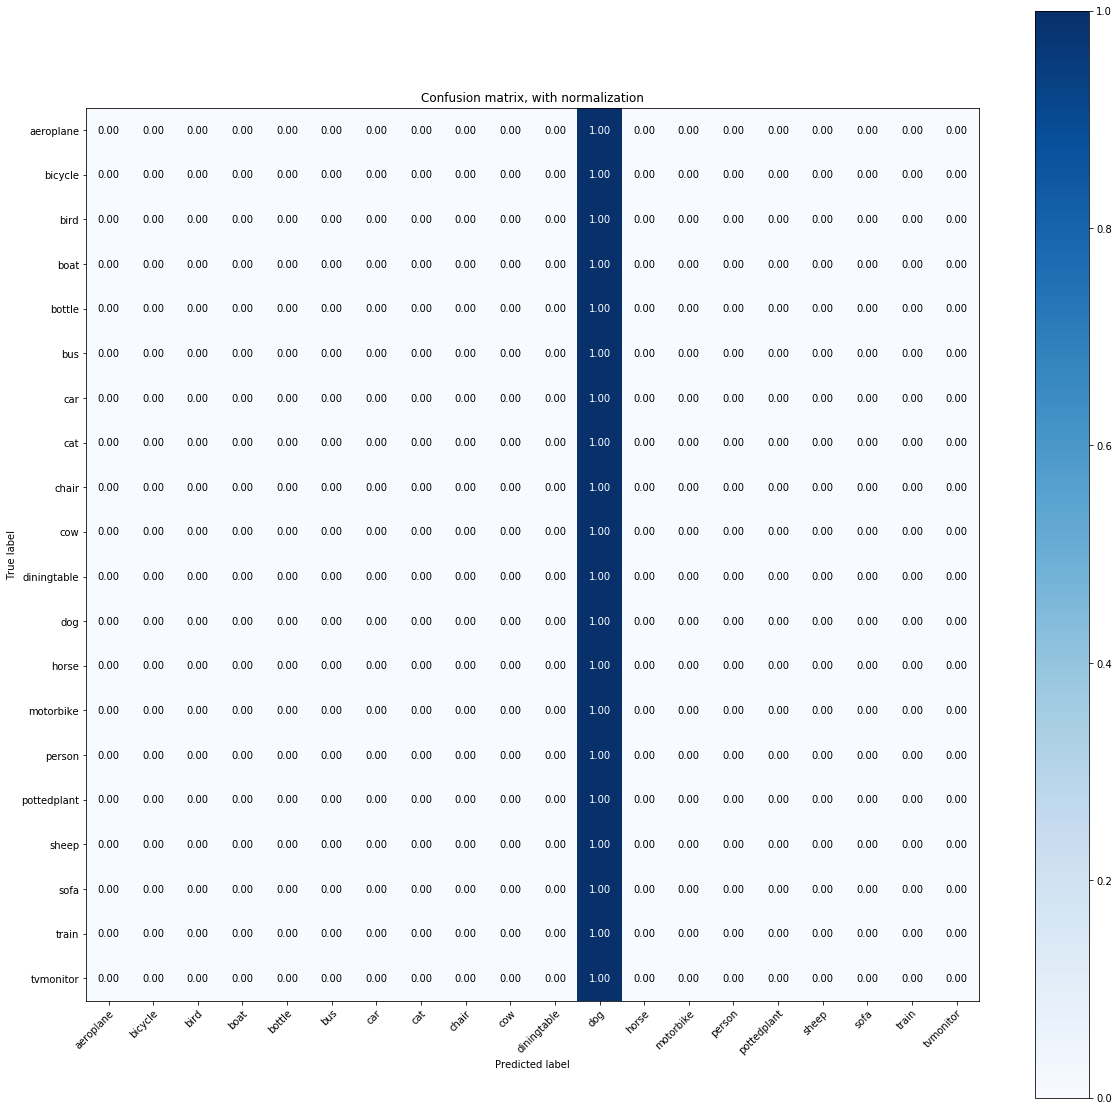

In [8]:
# Plot normalized confusion matrix
plot_confusion_matrix(true_classes, predicted_classes, classes=t_c,normalize=True,title='Confusion matrix, with normalization')

In [48]:
predictions

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)